In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2


In [3]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation,AveragePooling2D ,ReLU ,Add,Dense,Reshape,Multiply, Dropout, UpSampling2D,Conv2D,MaxPooling2D,concatenate,add,GlobalAveragePooling2D,GlobalMaxPool2D,Multiply

In [13]:
train_images =np.load("D:/projects/Lane_deep/Dataset/image_mixed.npy").astype(np.float32)
labels = np.load("D:/projects/Lane_deep/Dataset/label_mixed.npy").astype(np.float32)
train_images = np.array(train_images)
labels = np.array(labels)
labels = labels / 255
train_images, labels = shuffle(train_images, labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.3)
batch_size =64
epochs = 100
pool_size = (2, 2)
input_shape = X_train.shape[1:]

In [14]:
import tensorflow.keras.backend as K

def dsc(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dsc(y_true, y_pred)



def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
def unet():
    inputs = keras.layers.Input((80,160,3))
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = keras.models.Model(inputs = inputs, outputs = conv10)

   

    

    return model

In [16]:
model = unet()
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt,  loss = dice_loss, metrics = ['dsc','accuracy', 'IOU','precision_m', 'recall_m', 'f1_m'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 80, 160, 16)  448         ['input_2[0][0]']                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 80, 160, 16)  2320        ['conv2d_24[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 40, 80, 16)  0           ['conv2d_25[0][0]']        

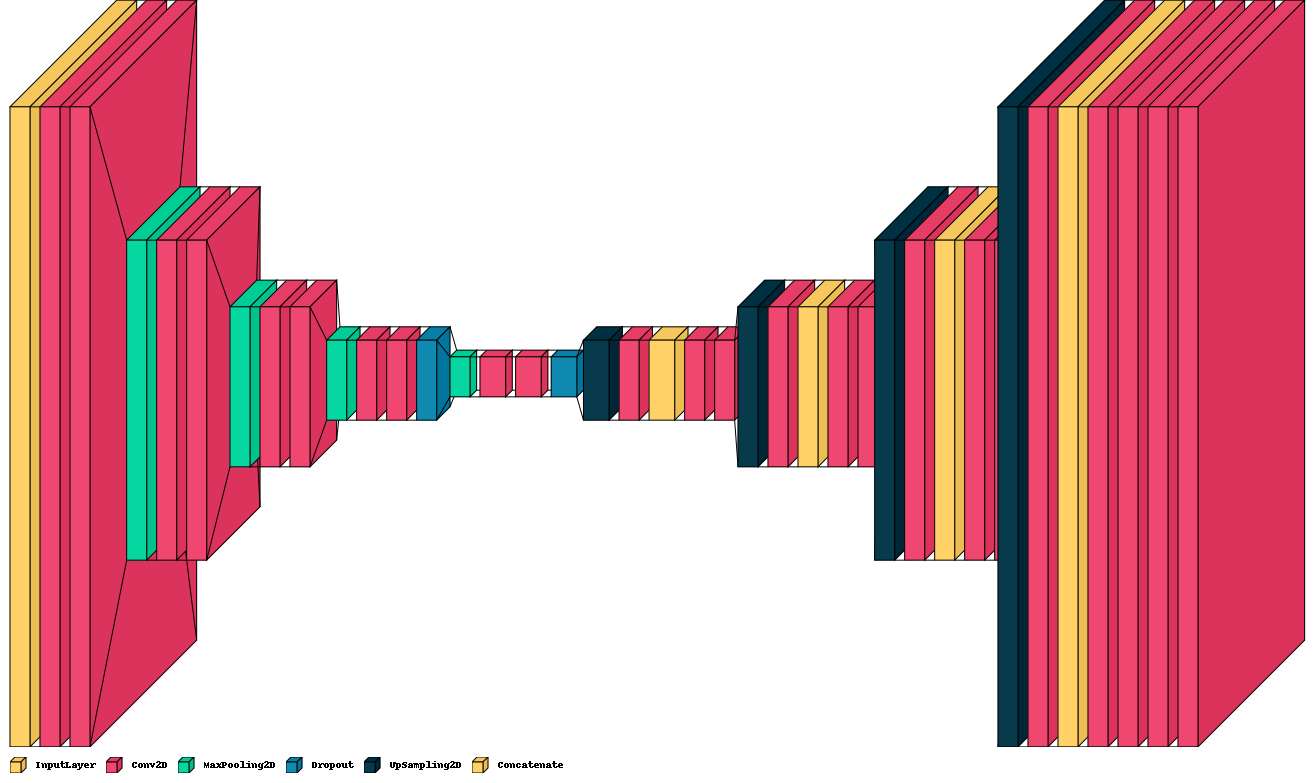

In [8]:
from PIL import ImageFont
visualkeras.layered_view(model, legend=True) 

In [17]:
model.save('D:/projects/lane_U.h5')

In [18]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model('D:/projects/Lane_U.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})
# summarize model.

In [19]:
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

model.save('D:/projects/Lane_U.h5')

C:\Users\USER\AppData\Local\Temp/ipykernel_7052/3488878094.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,


Epoch 1/100
164/164 [==============================] - 15s 66ms/step - loss: 0.2003 - dsc: 0.8003 - accuracy: 0.8614 - IOU: 0.6974 - precision_m: 0.7778 - recall_m: 0.8586 - f1_m: 0.8016 - val_loss: 0.0624 - val_dsc: 0.9376 - val_accuracy: 0.9501 - val_IOU: 0.8869 - val_precision_m: 0.9689 - val_recall_m: 0.9118 - val_f1_m: 0.9394
Epoch 2/100
164/164 [==============================] - 9s 57ms/step - loss: 0.0504 - dsc: 0.9487 - accuracy: 0.9530 - IOU: 0.9070 - precision_m: 0.9557 - recall_m: 0.9462 - f1_m: 0.9507 - val_loss: 0.0511 - val_dsc: 0.9490 - val_accuracy: 0.9524 - val_IOU: 0.9077 - val_precision_m: 0.9359 - val_recall_m: 0.9671 - val_f1_m: 0.9512
Epoch 3/100
164/164 [==============================] - 9s 57ms/step - loss: 0.0418 - dsc: 0.9583 - accuracy: 0.9559 - IOU: 0.9249 - precision_m: 0.9637 - recall_m: 0.9577 - f1_m: 0.9606 - val_loss: 0.0388 - val_dsc: 0.9612 - val_accuracy: 0.9573 - val_IOU: 0.9307 - val_precision_m: 0.9605 - val_recall_m: 0.9669 - val_f1_m: 0.9637
Epo

Epoch 26/100
164/164 [==============================] - 9s 57ms/step - loss: 0.0217 - dsc: 0.9784 - accuracy: 0.9622 - IOU: 0.9654 - precision_m: 0.9820 - recall_m: 0.9823 - f1_m: 0.9821 - val_loss: 0.0233 - val_dsc: 0.9767 - val_accuracy: 0.9617 - val_IOU: 0.9622 - val_precision_m: 0.9733 - val_recall_m: 0.9877 - val_f1_m: 0.9805
Epoch 27/100
164/164 [==============================] - 9s 58ms/step - loss: 0.0215 - dsc: 0.9785 - accuracy: 0.9623 - IOU: 0.9658 - precision_m: 0.9821 - recall_m: 0.9825 - f1_m: 0.9823 - val_loss: 0.0226 - val_dsc: 0.9774 - val_accuracy: 0.9619 - val_IOU: 0.9637 - val_precision_m: 0.9767 - val_recall_m: 0.9858 - val_f1_m: 0.9812
Epoch 28/100
164/164 [==============================] - 9s 58ms/step - loss: 0.0212 - dsc: 0.9788 - accuracy: 0.9624 - IOU: 0.9664 - precision_m: 0.9826 - recall_m: 0.9828 - f1_m: 0.9827 - val_loss: 0.0221 - val_dsc: 0.9779 - val_accuracy: 0.9621 - val_IOU: 0.9648 - val_precision_m: 0.9803 - val_recall_m: 0.9833 - val_f1_m: 0.9818
E

Epoch 51/100
164/164 [==============================] - 9s 57ms/step - loss: 0.0185 - dsc: 0.9814 - accuracy: 0.9631 - IOU: 0.9720 - precision_m: 0.9853 - recall_m: 0.9860 - f1_m: 0.9856 - val_loss: 0.0192 - val_dsc: 0.9808 - val_accuracy: 0.9628 - val_IOU: 0.9711 - val_precision_m: 0.9834 - val_recall_m: 0.9869 - val_f1_m: 0.9851
Epoch 52/100
164/164 [==============================] - 9s 57ms/step - loss: 0.0180 - dsc: 0.9820 - accuracy: 0.9632 - IOU: 0.9732 - precision_m: 0.9861 - recall_m: 0.9864 - f1_m: 0.9862 - val_loss: 0.0193 - val_dsc: 0.9807 - val_accuracy: 0.9628 - val_IOU: 0.9710 - val_precision_m: 0.9838 - val_recall_m: 0.9863 - val_f1_m: 0.9851
Epoch 53/100
164/164 [==============================] - 9s 57ms/step - loss: 0.0179 - dsc: 0.9821 - accuracy: 0.9633 - IOU: 0.9736 - precision_m: 0.9863 - recall_m: 0.9866 - f1_m: 0.9864 - val_loss: 0.0191 - val_dsc: 0.9809 - val_accuracy: 0.9628 - val_IOU: 0.9715 - val_precision_m: 0.9833 - val_recall_m: 0.9874 - val_f1_m: 0.9853
E

Epoch 76/100
164/164 [==============================] - 9s 58ms/step - loss: 0.0165 - dsc: 0.9835 - accuracy: 0.9636 - IOU: 0.9769 - precision_m: 0.9878 - recall_m: 0.9885 - f1_m: 0.9882 - val_loss: 0.0181 - val_dsc: 0.9819 - val_accuracy: 0.9630 - val_IOU: 0.9737 - val_precision_m: 0.9848 - val_recall_m: 0.9883 - val_f1_m: 0.9865
Epoch 77/100
164/164 [==============================] - 9s 57ms/step - loss: 0.0165 - dsc: 0.9835 - accuracy: 0.9636 - IOU: 0.9769 - precision_m: 0.9878 - recall_m: 0.9885 - f1_m: 0.9881 - val_loss: 0.0183 - val_dsc: 0.9817 - val_accuracy: 0.9630 - val_IOU: 0.9734 - val_precision_m: 0.9847 - val_recall_m: 0.9881 - val_f1_m: 0.9864
Epoch 78/100
164/164 [==============================] - 9s 57ms/step - loss: 0.0164 - dsc: 0.9835 - accuracy: 0.9636 - IOU: 0.9769 - precision_m: 0.9879 - recall_m: 0.9884 - f1_m: 0.9881 - val_loss: 0.0179 - val_dsc: 0.9821 - val_accuracy: 0.9631 - val_IOU: 0.9741 - val_precision_m: 0.9873 - val_recall_m: 0.9862 - val_f1_m: 0.9867
E

In [13]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

In [14]:
from numpy import savetxt
savetxt('train_loss.csv', train_loss, delimiter=',')
savetxt('valid_loss.csv', valid_loss, delimiter=',')

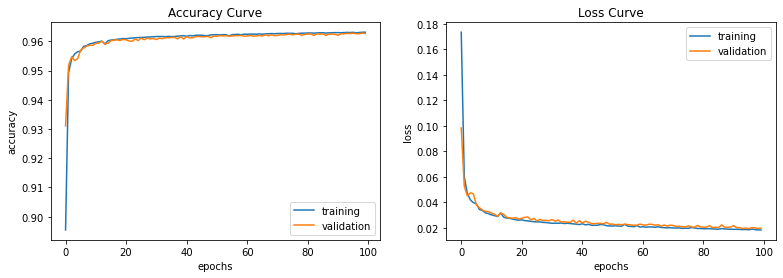

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [16]:
train_dice = history.history['dsc']
valid_dice = history.history['val_dsc']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

In [18]:
from numpy import savetxt
savetxt('train_dice.csv', train_dice, delimiter=',')
savetxt('valid_dice.csv', valid_dice, delimiter=',')

savetxt('train_IOU.csv', train_IOU, delimiter=',')
savetxt('valid_IOU.csv', valid_IOU, delimiter=',')

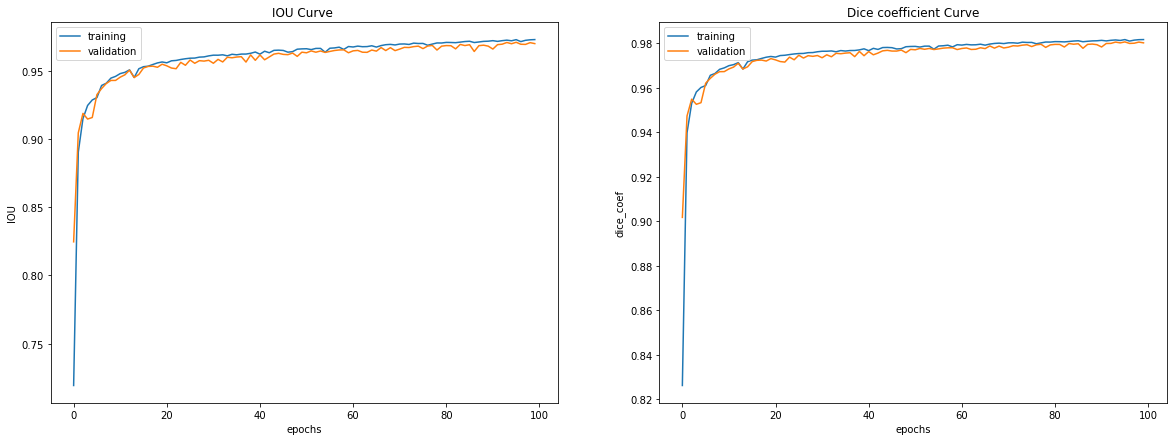

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve ')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()